In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install prophet
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import optuna
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/VNP.csv')
# Chuyển đổi cột thời gian thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Tạo DataFrame dữ liệu đầu vào
df = pd.DataFrame({'ds': data['Date'], 'y': data['Price']})
df

,ds,y
0,2017-12-01,5100
1,2017-12-04,5800
2,2017-12-05,5700
3,2017-12-06,5800
4,2017-12-07,6300
...,...,...
1225,2023-06-05,14700
1226,2023-06-06,14900
1227,2023-06-07,14800
1228,2023-06-08,14400


In [5]:
# Chia tập dữ liệu thành train-test-validate theo tỉ lệ
n = len(df)
n_train = int(n * 0.7)
n_test = int(n * 0.2)
n_validate = n - n_train - n_test

train_data = df[:n_train]
test_data = df[n_train:n_train + n_test]
validate_data = df[n_train + n_test:]

In [6]:
# Hàm mục tiêu để tối ưu hóa
def objective(trial):
    # Xác định không gian tìm kiếm cho siêu tham số
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 1.0),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0),
    }

    # Xây dựng mô hình BSTS với siêu tham số hiện tại
    model = Prophet(**params)
    model.fit(train_data)

    # Dự đoán trên tập test
    forecast = model.predict(test_data)

    # Tính toán độ đo RMSE để đánh giá mô hình
    rmse = mean_squared_error(test_data['y'], forecast['yhat'], squared=False)

    return rmse

In [7]:
# Tìm giá trị tối ưu cho siêu tham số
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=350)

# Lấy giá trị tối ưu cho siêu tham số
best_params = study.best_params

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] done processing
[I 2023-06-18 16:32:45,228] Trial 55 finished with value: 21836.904455940254 and parameters: {'changepoint_prior_scale': 9.998483523398699, 'seasonality_prior_scale': 0.14510101091978328, 'holidays_prior_scale': 0.05536140972775999}. Best is trial 41 with value: 20675.919820456063.
<ipython-input-6-bb80d6b1eb20>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
<ipython-input-6-bb80d6b1eb20>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'seasonality_prior_scale': trial.suggest_loguniform

In [8]:
# Xây dựng mô hình BSTS với siêu tham số tốt nhất
best_model = Prophet(**best_params)
best_model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbxcsf6ea/ua461ere.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbxcsf6ea/hyn3hizx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24536', 'data', 'file=/tmp/tmpbxcsf6ea/ua461ere.json', 'init=/tmp/tmpbxcsf6ea/hyn3hizx.json', 'output', 'file=/tmp/tmpbxcsf6ea/prophet_model_2u7ic3n/prophet_model-20230618163815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:38:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
print("Siêu tham số tối ưu:", best_params)

Siêu tham số tối ưu: {'changepoint_prior_scale': 8.93360230684565, 'seasonality_prior_scale': 0.27893580204009466, 'holidays_prior_scale': 0.03955952600845879}


In [10]:
# Dự đoán trên tập test và validate
test_forecast = best_model.predict(test_data)
validate_forecast = best_model.predict(validate_data)

In [11]:
# Dự đoán 30 ngày tiếp theo
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='D')
future_data = pd.DataFrame({'ds': future_dates})

future_forecast = best_model.predict(future_data)

In [12]:
# In kết quả dự đoán
future_forecast['yhat']

0     53995.583916
1     54089.781923
2     54179.537363
3     54220.366117
4     54355.422394
5     54498.282685
6     54580.966056
7     54641.206406
8     54740.571370
9     54829.797987
10    54864.050945
11    54986.284716
12    55110.035344
13    55167.444046
14    55196.528165
15    55259.294174
16    55307.063031
17    55295.714008
18    55369.028700
19    55441.461541
20    55446.139572
21    55422.107719
22    55432.415012
23    55429.412827
24    55369.972047
25    55398.801637
26    55431.195667
27    55401.012214
28    55347.900985
29    55335.375590
Name: yhat, dtype: float64

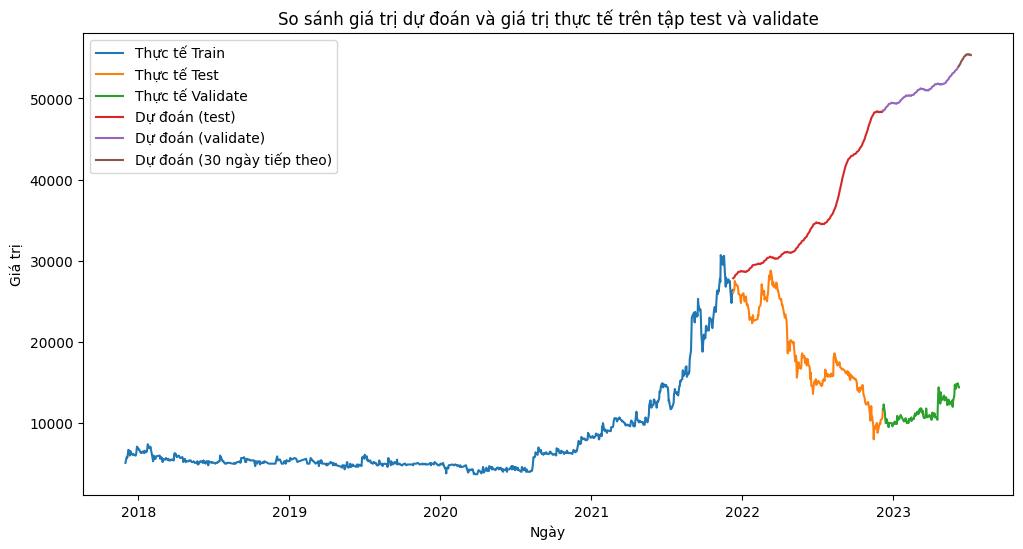

In [13]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Thực tế Train')
plt.plot(test_data['ds'], test_data['y'], label='Thực tế Test')
plt.plot(validate_data['ds'], validate_data['y'], label='Thực tế Validate')
plt.plot(test_data['ds'], test_forecast['yhat'], label='Dự đoán (test)')
plt.plot(validate_data['ds'], validate_forecast['yhat'], label='Dự đoán (validate)')
plt.plot(future_dates, future_forecast['yhat'], label='Dự đoán (30 ngày tiếp theo)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập test và validate')
plt.legend()
plt.show()

In [14]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho test data
rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat']))
mape = mean_absolute_percentage_error(test_data['y'], test_forecast['yhat'])*100
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
r2 = r2_score(test_data['y'], test_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 20441.887670381548
MAPE: 118.9732281193207
MSE: 417870771.5284971
MAE: 16922.93330272658
R2: -13.214533423495512


In [15]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho validate data
rmse = np.sqrt(mean_squared_error(validate_data['y'], validate_forecast['yhat']))
mape = mean_absolute_percentage_error(validate_data['y'], validate_forecast['yhat'])*100
mse = mean_squared_error(validate_data['y'], validate_forecast['yhat'])
mae = mean_absolute_error(validate_data['y'], validate_forecast['yhat'])
r2 = r2_score(validate_data['y'], validate_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 39611.31205743997
MAPE: 351.91313927382123
MSE: 1569056042.911889
MAE: 39602.39601984197
R2: -835.4263733067271
